In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

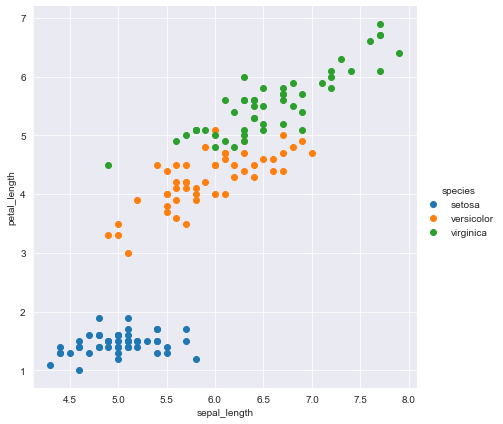

In [94]:
fisher_iris = pd.read_csv("https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv")
sns.set_style("darkgrid")
sns.FacetGrid(fisher_iris, hue ="species", height = 6).map(plt.scatter,
                              'sepal_length',
                              'petal_length').add_legend()

In [95]:
def initialize_centroids(k:int, data:pd.DataFrame):

    n_dims = data.shape[1]
    centroid_min = data.min().min()
    centroid_max = data.max().max()
    centroids = list()

    for centroid in range(k):
        centroid = np.random.uniform(centroid_min, centroid_max, n_dims)
        centroids.append(centroid)

    centroids = pd.DataFrame(centroids, columns = data.columns)

    return centroids

def calculate_error(a,b):
    error = np.square(np.sum((a-b) ** 2))

    return error 

def assign_centroid(data:pd.DataFrame, centroids:pd.DataFrame):
    n_observations = data.shape[0]
    centroid_assign = list()
    centroid_errors = list()
    k = centroids.shape[0]


    for observation in range(n_observations):

        # Calculate the errror
        errors = np.array([])
        for centroid in range(k):
            error = calculate_error(centroids.iloc[centroid, :2], data.iloc[observation,:2])
            errors = np.append(errors, error)

        # Calculate closest centroid & error 
        closest_centroid =  np.where(errors == np.amin(errors))[0].tolist()[0]
        centroid_error = np.amin(errors)

        # Assign values to lists
        centroid_assign.append(closest_centroid)
        centroid_errors.append(centroid_error)

    return centroid_assign, centroid_errors

def kmean(data:pd.DataFrame, k):
    # Initialize centroids
    centroids = initialize_centroids(k, data)
    error = []
    compr = True
    i = 0

    while(compr):
        # Obtain centroids and error
        data['centroid'], iter_error = assign_centroid(data,centroids)
        error = np.append(error, sum(iter_error))
        # Recalculate centroids
        centroids = data.groupby('centroid').agg('mean').reset_index(drop = True)

        # Re initialize centroids
        if(centroids.shape[0] < k):
            # warnings.warn("Cluster devanished! Consider reducing the number of k")
            ## raise Warning("Vanished centroid. Consider changing the number of clusters.")
            number_centroids_reinitialize = k - centroids.shape[0] 
            reinitialized_centroids = initialize_centroids(number_centroids_reinitialize, data.drop(['centroid'], axis = 1))

            # Find the index of the centroids that  are missing
            ind_missing = np.isin(np.array(range(k)), centroids.index)
            reinitialized_centroids.index = np.array(range(k))[ind_missing == False]

            # Include the new centroids
            centroids = pd.concat([centroids, reinitialized_centroids])

        # Check if the error has decreased
        if(len(error)<2):
            compr = True
        else:
            if(round(error[i],3) !=  round(error[i-1], 3)):
                compr = True
            else:
                compr = False
        i = i + 1

    return data['centroid'], error, centroids

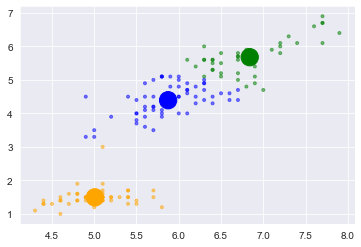

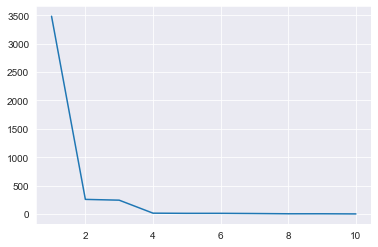

In [96]:
data = fisher_iris[["sepal_length", "petal_length"]]

colors = {0:'green', 1:'orange', 2:'blue'}

num_trials = 10

classifications = list()
errors = list()
centroids = list()
total_errors = list()

for i in range(num_trials):

    np.random.seed(i)

    iter_class, iter_error, iter_centroid = kmean(data, 3)

    classifications.append(iter_class)
    errors.append(sum(iter_error))
    centroids.append(iter_centroid)
    _, it_error, _ = kmean(data, i + 1)
    total_errors.append(it_error[-1])

errors = np.array(errors)
best_ind = np.where(errors == errors.min())[0].tolist()[0]

data['centroid'] = classifications[best_ind]

plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = '.', c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids[best_ind].iloc[:,0], centroids[best_ind].iloc[:,1],  marker = 'o', s = 300, c = centroids[best_ind].index.map(lambda x: colors[x]))
plt.show()

plt.plot(range(1,11), total_errors)
plt.show()